In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
directory = '/content/drive/MyDrive/Thesis'
data_dir = directory + "/Data"

In [ ]:
#loaded = np.load(f'{data_dir}/demand_graph_timestamps.pkl.npz')
#demand_timestamps_graphs = [loaded[f'arr_{i}'] for i in range(len(loaded))]
#length = 0


loaded = np.load(f'{data_dir}/demand_graphs.pkl.npz')
demand_graphs = [loaded[f'arr_{i}'] for i in range(2160, 3600)]

#print(demand_graphs)



#print(demand_graphs)

Exception ignored in: <function NpzFile.__del__ at 0x7e12ea1a4430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 226, in __del__
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 221, in close
OSError: [Errno 107] Transport endpoint is not connected


In [ ]:
#demand_timestamps_graphs[744]#[0][2]

In [ ]:
class TripData(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [ ]:
class GNN_LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GNN_LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device)
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns.

    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

In [ ]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss() # Define your loss function, do not modify this.

    # Define your optimization algorithm.
    optimizer=torch.optim.Adam(model.parameters(),lr=config['learning_rate'],betas=(0.5,0.999))

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())

            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())

        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Test loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/Test', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [ ]:
print(f"len(graphs):{len(demand_graphs)}")

len(graphs):1440


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 20010106,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'test_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.
    'batch_size': 16,
    'learning_rate': 5e-5,
    'early_stop': 50,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': f'{directory}/models/GNNLSTM_2.ckpt'  # Your model will be saved here.
}

In [ ]:
def split_data(data, time_step=5):
    dataX=[]
    datay=[]
    dataNew = []
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
        dataNew.append(data[i:i+time_step+1])
    dataX=np.array(dataX).reshape(len(dataX),time_step,-1)
    datay=np.array(datay)
    dataNew=np.array(dataNew).reshape(len(dataNew),time_step+1,-1)
    return dataX,datay,dataNew

In [ ]:
dataX, datay, dataNew = split_data(demand_graphs)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape},dataNew.shape:{dataNew.shape}")

dataX.shape:(1435, 5, 35344),datay.shape:(1435, 188, 188),dataNew.shape:(1435, 6, 35344)


In [ ]:
del demand_graphs

In [ ]:

valid_size = int(len(dataNew) * 0.1)
valid_data = dataNew[-valid_size:]

In [ ]:
valid_data[6].sum()

1487.0

In [ ]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_test_split(data_set, test_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(test_ratio * len(data_set))
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

In [ ]:
train_data, test_data = train_test_split(dataNew, config['test_ratio'], config['seed'])

# Select features
x_train, x_test, y_train, y_test = train_data[:,:-1], test_data[:,:-1], train_data[:,-1], test_data[:,-1],

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

len(train_data)

number of features: 5


1148

In [ ]:
train_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
    

In [ ]:
train_dataset, valid_dataset = TripData(x_train, y=y_train), TripData(x_test, y=y_test),

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

In [ ]:
input_size = dataNew.shape[2]
hidden_size = 256
num_layers = 8
output_size = dataNew.shape[2]

input_size = dataNew.shape[2]
print(dataNew.shape[2])

35344


In [ ]:
dataNew[1].shape

(6, 35344)

In [ ]:
model = GNN_LSTM_model(input_size, hidden_size, num_layers, output_size).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|██████████| 72/72 [02:18<00:00,  1.93s/it, loss=0.00878]


Epoch [1/500]: Train loss: 0.0114, Test loss: 0.0099
Saving model with loss 0.010...


Epoch [2/500]: 100%|██████████| 72/72 [02:20<00:00,  1.95s/it, loss=0.00629]


Epoch [2/500]: Train loss: 0.0100, Test loss: 0.0091
Saving model with loss 0.009...


Epoch [3/500]: 100%|██████████| 72/72 [02:21<00:00,  1.96s/it, loss=0.011]


Epoch [3/500]: Train loss: 0.0097, Test loss: 0.0090
Saving model with loss 0.009...


Epoch [4/500]: 100%|██████████| 72/72 [02:19<00:00,  1.94s/it, loss=0.00511]


Epoch [4/500]: Train loss: 0.0096, Test loss: 0.0090
Saving model with loss 0.009...


Epoch [5/500]: 100%|██████████| 72/72 [02:21<00:00,  1.97s/it, loss=0.0105]


Epoch [5/500]: Train loss: 0.0094, Test loss: 0.0088
Saving model with loss 0.009...


Epoch [6/500]: 100%|██████████| 72/72 [02:20<00:00,  1.94s/it, loss=0.00973]


Epoch [6/500]: Train loss: 0.0093, Test loss: 0.0087
Saving model with loss 0.009...


Epoch [7/500]: 100%|██████████| 72/72 [02:21<00:00,  1.96s/it, loss=0.00597]


Epoch [7/500]: Train loss: 0.0092, Test loss: 0.0087
Saving model with loss 0.009...


Epoch [8/500]: 100%|██████████| 72/72 [02:21<00:00,  1.96s/it, loss=0.00751]


Epoch [8/500]: Train loss: 0.0092, Test loss: 0.0086
Saving model with loss 0.009...


Epoch [9/500]: 100%|██████████| 72/72 [02:23<00:00,  2.00s/it, loss=0.00639]


Epoch [9/500]: Train loss: 0.0091, Test loss: 0.0086
Saving model with loss 0.009...


Epoch [10/500]: 100%|██████████| 72/72 [02:22<00:00,  1.98s/it, loss=0.00713]


Epoch [10/500]: Train loss: 0.0091, Test loss: 0.0085
Saving model with loss 0.009...


Epoch [11/500]: 100%|██████████| 72/72 [02:20<00:00,  1.95s/it, loss=0.00581]


Epoch [11/500]: Train loss: 0.0090, Test loss: 0.0085
Saving model with loss 0.009...


Epoch [12/500]: 100%|██████████| 72/72 [02:19<00:00,  1.94s/it, loss=0.0111]


Epoch [12/500]: Train loss: 0.0090, Test loss: 0.0085
Saving model with loss 0.008...


Epoch [13/500]: 100%|██████████| 72/72 [02:22<00:00,  1.98s/it, loss=0.00867]


Epoch [13/500]: Train loss: 0.0090, Test loss: 0.0085
Saving model with loss 0.008...


Epoch [14/500]: 100%|██████████| 72/72 [02:20<00:00,  1.95s/it, loss=0.00801]


Epoch [14/500]: Train loss: 0.0090, Test loss: 0.0085
Saving model with loss 0.008...


Epoch [15/500]: 100%|██████████| 72/72 [02:24<00:00,  2.01s/it, loss=0.00827]


Epoch [15/500]: Train loss: 0.0090, Test loss: 0.0085
Saving model with loss 0.008...


Epoch [16/500]: 100%|██████████| 72/72 [02:19<00:00,  1.94s/it, loss=0.0108]


Epoch [16/500]: Train loss: 0.0090, Test loss: 0.0085
Saving model with loss 0.008...


Epoch [17/500]: 100%|██████████| 72/72 [02:18<00:00,  1.92s/it, loss=0.00777]


Epoch [17/500]: Train loss: 0.0089, Test loss: 0.0085


Epoch [18/500]: 100%|██████████| 72/72 [02:24<00:00,  2.01s/it, loss=0.0132]


Epoch [18/500]: Train loss: 0.0090, Test loss: 0.0085


Epoch [19/500]: 100%|██████████| 72/72 [02:21<00:00,  1.96s/it, loss=0.00974]


Epoch [19/500]: Train loss: 0.0089, Test loss: 0.0084
Saving model with loss 0.008...


Epoch [20/500]: 100%|██████████| 72/72 [02:23<00:00,  1.99s/it, loss=0.0108]


Epoch [20/500]: Train loss: 0.0090, Test loss: 0.0084
Saving model with loss 0.008...


Epoch [21/500]: 100%|██████████| 72/72 [02:19<00:00,  1.94s/it, loss=0.00707]


Epoch [21/500]: Train loss: 0.0089, Test loss: 0.0085


Epoch [22/500]: 100%|██████████| 72/72 [02:20<00:00,  1.95s/it, loss=0.00733]


Epoch [22/500]: Train loss: 0.0089, Test loss: 0.0085


Epoch [23/500]: 100%|██████████| 72/72 [02:19<00:00,  1.93s/it, loss=0.00618]


Epoch [23/500]: Train loss: 0.0089, Test loss: 0.0085


Epoch [24/500]: 100%|██████████| 72/72 [02:21<00:00,  1.96s/it, loss=0.0104]


Epoch [24/500]: Train loss: 0.0089, Test loss: 0.0084


Epoch [25/500]: 100%|██████████| 72/72 [02:21<00:00,  1.96s/it, loss=0.00958]


Epoch [25/500]: Train loss: 0.0089, Test loss: 0.0085


Epoch [26/500]: 100%|██████████| 72/72 [02:24<00:00,  2.00s/it, loss=0.00842]


Epoch [26/500]: Train loss: 0.0089, Test loss: 0.0085


Epoch [27/500]:  44%|████▍     | 32/72 [01:04<01:20,  2.02s/it, loss=0.00963]


KeyboardInterrupt: 

In [ ]:
model = GNN_LSTM_model(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load(config['save_path']))

<ipython-input-30-ba139eee971b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['save_path']))


<All keys matched successfully>

In [ ]:
valid_dataset =  TripData(valid_data)

In [ ]:
valid_dataset

In [ ]:
y_valid=valid_data[:,-1]

In [ ]:
y_valid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
pred_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)

In [ ]:
preds = predict(pred_loader, model, device)

100%|██████████| 143/143 [00:47<00:00,  2.99it/s]


In [ ]:
y_valid.shape

(143, 35344)

In [ ]:
y_valid_reshaped = np.sum(y_valid.reshape(143, 188, 188), axis=2)

In [ ]:
preds_reshaped = np.sum(preds.reshape(143, 188, 188), axis=2)


In [ ]:
y_valid_passenger_count = [cycle[0] for cycle in y_valid_reshaped]
preds_passenger_count = [cycle[0] for cycle in preds_reshaped]

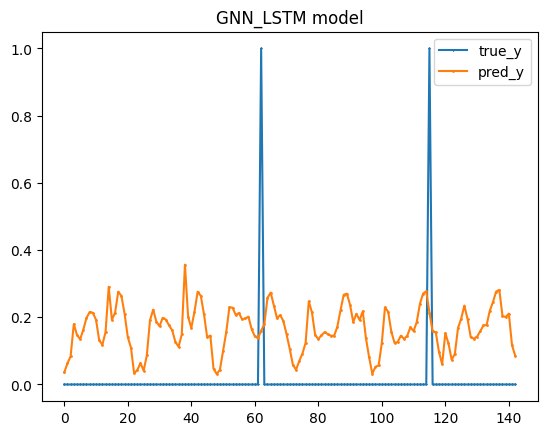

In [ ]:
plt.title("GNN_LSTM model")
x=[i for i in range(len(y_valid))]
plt.plot(x,y_valid_passenger_count,marker="x",markersize=1,label="true_y")
plt.plot(x,preds_passenger_count,marker="o",markersize=1,label="pred_y")
plt.legend()
plt.show()